In [1]:
%config IPCompleter.greedy = True

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import cv2

import tensorflow.compat.v2 as tf
from tensorflow.compat.v2 import keras
from tensorflow.compat.v2.keras import layers

### 讀取資料
- Intel Image Classification: https://www.kaggle.com/puneet6060/intel-image-classification

In [3]:
train_data_path = '../input/intel-image-classification/seg_train/seg_train'
test_data_path = '../input/intel-image-classification/seg_test/seg_test'
pred_data_path = '../input/intel-image-classification/seg_pred'

In [4]:
tag_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
class_dict = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


def make_datasets(data_path):
    images = []
    tags = []

    for tag_dir in os.listdir(data_path):
        for image_file in os.listdir(os.path.join(data_path, tag_dir)):
            image = cv2.imread(os.path.join(data_path, tag_dir, image_file))
            image = cv2.resize(image, (32, 32))
            images.append(image)
            tags.append(tag_dict.get(tag_dir, 0))
    return tf.data.Dataset.from_tensor_slices(({'image': images, 'tag': tags}))


train_dataset = make_datasets(train_data_path)
test_dataset = make_datasets(test_data_path)

In [5]:
# 訓練資料
train_data = train_dataset.take(12600)
# 驗證資料
valid_data = train_dataset.skip(12600)
# 測試資料
test_data = test_dataset

### 資料分析

In [6]:
# 建立一個 dict，用來儲存每個類別數量
train_dict = {}

# 讀取整個資料集
for data in train_data:
    # 將讀取到的 label 轉成 numpy 格式
    label = data['tag'].numpy()
    # 計算每個類別數量
    train_dict[label] = train_dict.setdefault(label, 0) + 1

# 查看訓練資料的每個類別數量
train_dict

{0: 2191, 2: 2404, 4: 2274, 3: 2512, 1: 2271, 5: 948}

In [7]:
train_num = 0
for i in train_dict.values():
    train_num += i
print(train_num)

12600


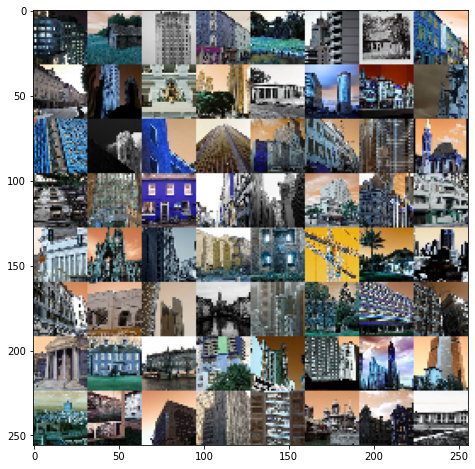

In [8]:
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# 每次取 8 筆資料，共取 8 次，所以總共取得 64 筆資料
for data in train_data.batch(8).take(8):
    # 將取得的 8 筆資料堆疊起來，放入顯示影像陣列第 N 列中
    output[:, row * 32: (row + 1) * 32] = np.vstack(data['image'].numpy())
    row += 1

# 設定顯示視窗大小
plot.figure(figsize=(8, 8))
# 顯示資料集部分影像資料
plot.imshow(output)

### 影像增強 (Image Augmentation)

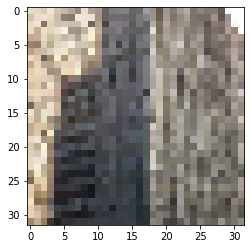

In [9]:
# 讀取原始影像
x = 3
y = 7
# 讀取測試影像
image_test = output[y * 32: (y + 1) * 32, x * 32: (x + 1) * 32, :]
# 顯示影像
plot.imshow(image_test)


def show_images(new_image):
    # 將處理前後的影像作水平合併
    images = np.hstack((image_test, new_image))
    # 顯示影像
    plot.imshow(images)

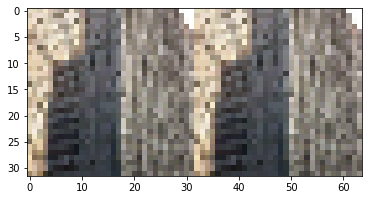

In [10]:
# 水平翻轉
def flip(x):
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像

    return x


new_image = flip(image_test)
show_images(new_image)

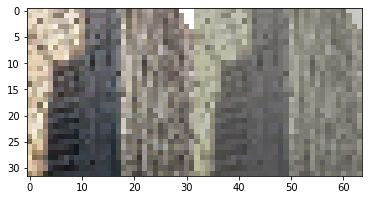

In [11]:
# 顏色轉換
def color(x):
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.07, 1.3)  # 隨機調整影像對比度

    return x


new_image = color(image_test)
show_images(new_image)

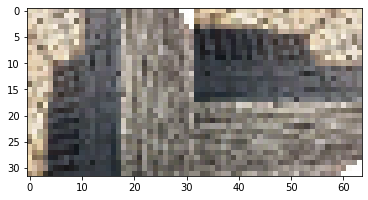

In [12]:
# 影像旋轉
def rotate(x):
    # 隨機旋轉 n 次 (透過 minval 和 maxval 設定 n 的範圍)，每次旋轉 90 度
    x = tf.image.rot90(
        x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32)
    )

    return x


new_image = rotate(image_test)
show_images(new_image)

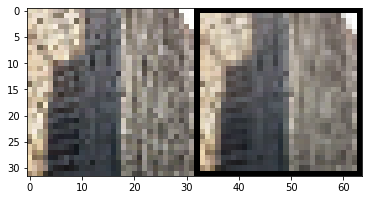

In [13]:
# 影像縮放
def zoom(x, scale_min=0.6, scale_max=1.4):
    height, weight, color = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    scale_height = height * scale  # 縮放後的影像長度
    scale_weight = weight * scale  # 縮放後的影像寬度
    x = tf.image.resize(x, (scale_height, scale_weight))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, height, weight)  # 影像裁減和填補

    return x


new_image = zoom(image_test)
# 因為處理後影像會變成浮點數型態，所以需轉換回來，不然顯示時會出現問題
new_image = tf.cast(new_image, dtype=tf.uint8)
show_images(new_image)

### 資料預處理 (Data Preprocessing)

In [14]:
def image_augmentation(dataset):
    # 影像標準化: 將所有像素除以 255，讓像素縮放至 0 ~ 1 之間
    x = tf.cast(dataset['image'], tf.float32) / 255

    # 影像增強: 隨機水平翻專
    x = flip(x)
    # 觸發顏色轉換機率 50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率 25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率 50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)

    # 標籤標準化: 轉成 One-hot Encoding
    y = tf.one_hot(dataset['tag'], 6)

    return x, y

### 資料集設定 (影像增強)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小

# 打散資料
train_data = train_data.shuffle(train_num)
# 載入預處理函式，CPU 數量為自動調整模式
train_data = train_data.map(map_func=image_augmentation, num_parallel_calls=AUTOTUNE)
# 設定批次大小為 64，並將 prefetch 模式開啟，暫存空間為自動調整模式
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=image_augmentation, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=image_augmentation, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

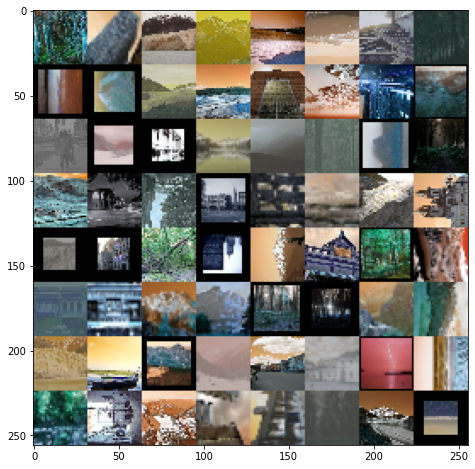

In [16]:
# 測試資料集經過影像增強 (Image Augmentation) 後的結果
# 因為前面已經將 train_data batch size 設定為 64，所以取一次資料就會有 64 筆
for images, labels in train_data.take(1):
    images = images.numpy()

# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將 64 筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i * 32: (i + 1) * 32, j * 32: (j + 1) * 32, :] = images[i * 8 + j]

# 設定顯示視窗大小
plot.figure(figsize=(8, 8))
# 顯示資料集部分影像資料
plot.imshow(output)

### 訓練 Model-1 (使用影像增強後的資料集訓練卷積神經網路)

In [17]:
# 輸入層: 影像大小為 32 x 32 x 3(RGB)
inputs = keras.Input(shape=(32, 32, 3))
# 卷積層: 使用 3x3 大小的 kernel. ReLU 激活函數
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
# 池化層: 對特徵圖下採樣
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# 扁平層: 特徵圖轉為一維 Tensor
x = layers.Flatten()(x)
# 隱藏層(全連結層): 使用 ReLU 激活函數
x = layers.Dense(64, activation='relu')(x)
# 捨棄層: 每次訓練隨機丟棄 50% 神經元
x = layers.Dropout(0.5)(x)
# 輸出層(全連結層): 使用 Softmax 激活函數
outputs = layers.Dense(6, activation='softmax')(x)

# 建立網路模型
model_1 = keras.Model(inputs, outputs, name='model-1')
# 顯示網路架構
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [18]:
# 建立模型儲存目錄
model_dir = os.path.join('logs', 'models')
if os.path.exists('logs'):
    shutil.rmtree('logs')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [19]:
# 建立回調函數 (Callback function)
# 將訓練記錄存成 TensorBoard 的紀錄檔
log_dir = os.path.join('logs', 'model-1')
model_tb = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mcp = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, 'Best-model-1.h5'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
)

In [20]:
# 設定訓練使用的優化器. 損失函數和指標函數
model_1.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [21]:
# 訓練網路模型
history_1 = model_1.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_tb, model_mcp],
                        verbose=0)

### 訓練 Model-2

In [22]:
# 輸入層: 影像大小為 32 x 32 x 3(RGB)
inputs = keras.Input(shape=(32, 32, 3))
# 卷積層: 使用 3x3 大小的 kernel. ReLU 激活函數
x = layers.Conv2D(200, (3, 3), activation='relu')(inputs)
x = layers.Conv2D(180, (3, 3), activation='relu')(inputs)
# 池化層: 對特徵圖下採樣
x = layers.MaxPool2D()(x)
x = layers.Conv2D(180, (3, 3), activation='relu')(x)
x = layers.Conv2D(140, (3, 3), activation='relu')(x)
x = layers.Conv2D(100, (3, 3), activation='relu')(x)
x = layers.Conv2D(50, (3, 3), activation='relu')(x)
x = layers.MaxPool2D(5, 5)(x)
# 扁平層: 特徵圖轉為一維 Tensor
x = layers.Flatten()(x)
# 隱藏層(全連結層): 使用 ReLU 激活函數
x = layers.Dense(180, activation='relu')(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dense(50, activation='relu')(x)
# 捨棄層: 每次訓練隨機丟棄 50% 神經元
x = layers.Dropout(0.5)(x)
# 輸出層(全連結層): 使用 Softmax 激活函數
outputs = layers.Dense(6, activation='softmax')(x)

# 建立網路模型
model_2 = keras.Model(inputs, outputs, name='model-2')
# 顯示網路架構
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 180)       5040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 180)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 180)       291780    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 140)       226940    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 100)         126100    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 50)          4505

In [23]:
# 建立回調函數 (Callback function)
# 將訓練記錄存成 TensorBoard 的紀錄檔
log_dir = os.path.join('logs', 'model-2')
model_tb = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mcp = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, 'Best-model-2.h5'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
)

# 設定訓練使用的優化器. 損失函數和指標函數
model_2.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# 訓練網路模型
history_2 = model_2.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_tb, model_mcp],
                        verbose=0)

### 訓練 Model-3

In [24]:
# 輸入層: 影像大小為 32 x 32 x 3(RGB)
inputs = keras.Input(shape=(32, 32, 3))
# 卷積層: 使用 3x3 大小的 kernel. ReLU 激活函數
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
# 池化層: 對特徵圖下採樣
x = layers.MaxPool2D()(x)
x = layers.Conv2D(100, (3, 3), activation='relu')(x)
x = layers.Conv2D(100, (3, 3), activation='relu')(x)
x = layers.Conv2D(100, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# 扁平層: 特徵圖轉為一維 Tensor
x = layers.Flatten()(x)
# 隱藏層(全連結層): 使用 ReLU 激活函數
x = layers.Dense(64, activation='relu')(x)
# 捨棄層: 每次訓練隨機丟棄 50% 神經元
x = layers.Dropout(0.5)(x)
# 輸出層(全連結層): 使用 Softmax 激活函數
outputs = layers.Dense(6, activation='softmax')(x)

# 建立網路模型
model_3 = keras.Model(inputs, outputs, name='model-3')
# 顯示網路架構
model_3.summary()

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 100)       57700     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 100)       90100     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 9, 100)         90100     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          5766

In [25]:
# 建立回調函數 (Callback function)
# 將訓練記錄存成 TensorBoard 的紀錄檔
log_dir = os.path.join('logs', 'model-3')
model_tb = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mcp = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, 'Best-model-3.h5'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
)

# 設定訓練使用的優化器. 損失函數和指標函數
model_3.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# 訓練網路模型
history_3 = model_3.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_tb, model_mcp],
                        verbose=0)

### 訓練 Model-4

In [26]:
# 輸入層: 影像大小為 32 x 32 x 3(RGB)
inputs = keras.Input(shape=(32, 32, 3))
# 卷積層: 使用 3x3 大小的 kernel. ReLU 激活函數
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
# 池化層: 對特徵圖下採樣
x = layers.MaxPool2D()(x)
x = layers.Conv2D(50, (3, 3), activation='relu')(x)
x = layers.Conv2D(50, (3, 3), activation='relu')(x)
x = layers.Conv2D(50, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# 扁平層: 特徵圖轉為一維 Tensor
x = layers.Flatten()(x)
# 隱藏層(全連結層): 使用 ReLU 激活函數
x = layers.Dense(64, activation='relu')(x)
# 捨棄層: 每次訓練隨機丟棄 50% 神經元
x = layers.Dropout(0.5)(x)
# 輸出層(全連結層): 使用 Softmax 激活函數
outputs = layers.Dense(6, activation='softmax')(x)

# 建立網路模型
model_4 = keras.Model(inputs, outputs, name='model-4')
# 顯示網路架構
model_4.summary()

Model: "model-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 50)        28850     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 11, 11, 50)        22550     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 9, 9, 50)          22550     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 64)          2886

In [27]:
# 建立回調函數 (Callback function)
# 將訓練記錄存成 TensorBoard 的紀錄檔
log_dir = os.path.join('logs', 'model-4')
model_tb = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mcp = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, 'Best-model-4.h5'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
)

# 設定訓練使用的優化器. 損失函數和指標函數
model_4.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# 訓練網路模型
history_4 = model_4.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_tb, model_mcp],
                        verbose=0)

### 訓練 Model-5

In [28]:
# 輸入層: 影像大小為 32 x 32 x 3(RGB)
inputs = keras.Input(shape=(32, 32, 3))
# 卷積層: 使用 3x3 大小的 kernel. ReLU 激活函數
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
# 池化層: 對特徵圖下採樣
x = layers.MaxPool2D()(x)
x = layers.Conv2D(200, (3, 3), activation='relu')(x)
x = layers.Conv2D(200, (3, 3), activation='relu')(x)
x = layers.Conv2D(200, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# 扁平層: 特徵圖轉為一維 Tensor
x = layers.Flatten()(x)
# 隱藏層(全連結層): 使用 ReLU 激活函數
x = layers.Dense(64, activation='relu')(x)
# 捨棄層: 每次訓練隨機丟棄 50% 神經元
x = layers.Dropout(0.5)(x)
# 輸出層(全連結層): 使用 Softmax 激活函數
outputs = layers.Dense(6, activation='softmax')(x)

# 建立網路模型
model_5 = keras.Model(inputs, outputs, name='model-5')
# 顯示網路架構
model_5.summary()

Model: "model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 200)       115400    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 200)       360200    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 9, 200)         360200    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          1152

In [29]:
# 建立回調函數 (Callback function)
# 將訓練記錄存成 TensorBoard 的紀錄檔
log_dir = os.path.join('logs', 'model-5')
model_tb = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mcp = keras.callbacks.ModelCheckpoint(
    os.path.join(model_dir, 'Best-model-5.h5'),
    monitor='val_categorical_accuracy',
    save_best_only=True,
    mode='max',
)

# 設定訓練使用的優化器. 損失函數和指標函數
model_5.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# 訓練網路模型
history_5 = model_5.fit(train_data,
                        epochs=100,
                        validation_data=valid_data,
                        callbacks=[model_tb, model_mcp],
                        verbose=0)

### 訓練結果

In [30]:
# 讀取各自最佳的網路權重
model_1.load_weights(os.path.join('logs','models','Best-model-1.h5'))
model_2.load_weights(os.path.join('logs','models','Best-model-2.h5'))
model_3.load_weights(os.path.join('logs','models','Best-model-3.h5'))
model_4.load_weights(os.path.join('logs','models','Best-model-4.h5'))
model_5.load_weights(os.path.join('logs','models','Best-model-5.h5'))

In [31]:
# 驗證在測試資料集上
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)
loss_4, acc_4 = model_4.evaluate(test_data)
loss_5, acc_5 = model_4.evaluate(test_data)

47/47 [==============================] - 1s 19ms/step - loss: 0.7626 - categorical_accuracy: 0.7217


In [32]:
# 顯示預測的損失值與準確度結果
acc = [acc_1, acc_2, acc_3, acc_4, acc_5]
loss = [loss_1, loss_2, loss_3, loss_4, loss_5]
pd.DataFrame({'Accuracy': acc, 'Loss': loss})

,Accuracy,Loss
0,0.750000,0.734209
1,0.718667,0.803500
2,0.738667,0.759061
3,0.720000,0.736999
4,0.721667,0.762573


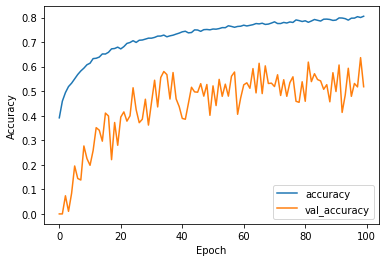

In [33]:
# Model-1 的準確度圖表
plot.plot(history_1.history['categorical_accuracy'], label='accuracy')
plot.plot(history_1.history['val_categorical_accuracy'], label='val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(loc='lower right')

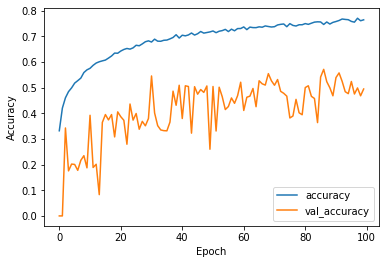

In [34]:
# Model-2 的準確度圖表
plot.plot(history_2.history['categorical_accuracy'], label='accuracy')
plot.plot(history_2.history['val_categorical_accuracy'], label='val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(loc='lower right')

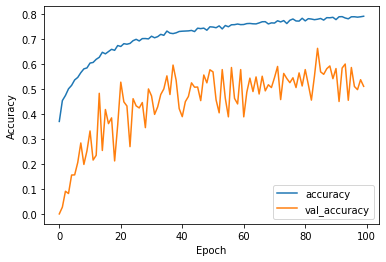

In [35]:
# Model-3 的準確度圖表
plot.plot(history_3.history['categorical_accuracy'], label='accuracy')
plot.plot(history_3.history['val_categorical_accuracy'], label='val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(loc='lower right')

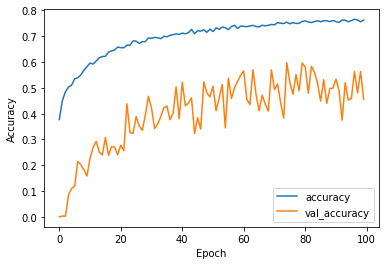

In [36]:
# Model-4 的準確度圖表
plot.plot(history_4.history['categorical_accuracy'], label='accuracy')
plot.plot(history_4.history['val_categorical_accuracy'], label='val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(loc='lower right')

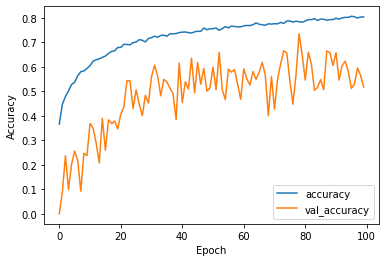

In [37]:
# Model-5 的準確度圖表
plot.plot(history_5.history['categorical_accuracy'], label='accuracy')
plot.plot(history_5.history['val_categorical_accuracy'], label='val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend(loc='lower right')

### 預測結果

In [38]:
pred_data = make_datasets(pred_data_path)
pred_data

<TensorSliceDataset shapes: {image: (32, 32, 3), tag: ()}, types: {image: tf.int32, tag: tf.int32}>

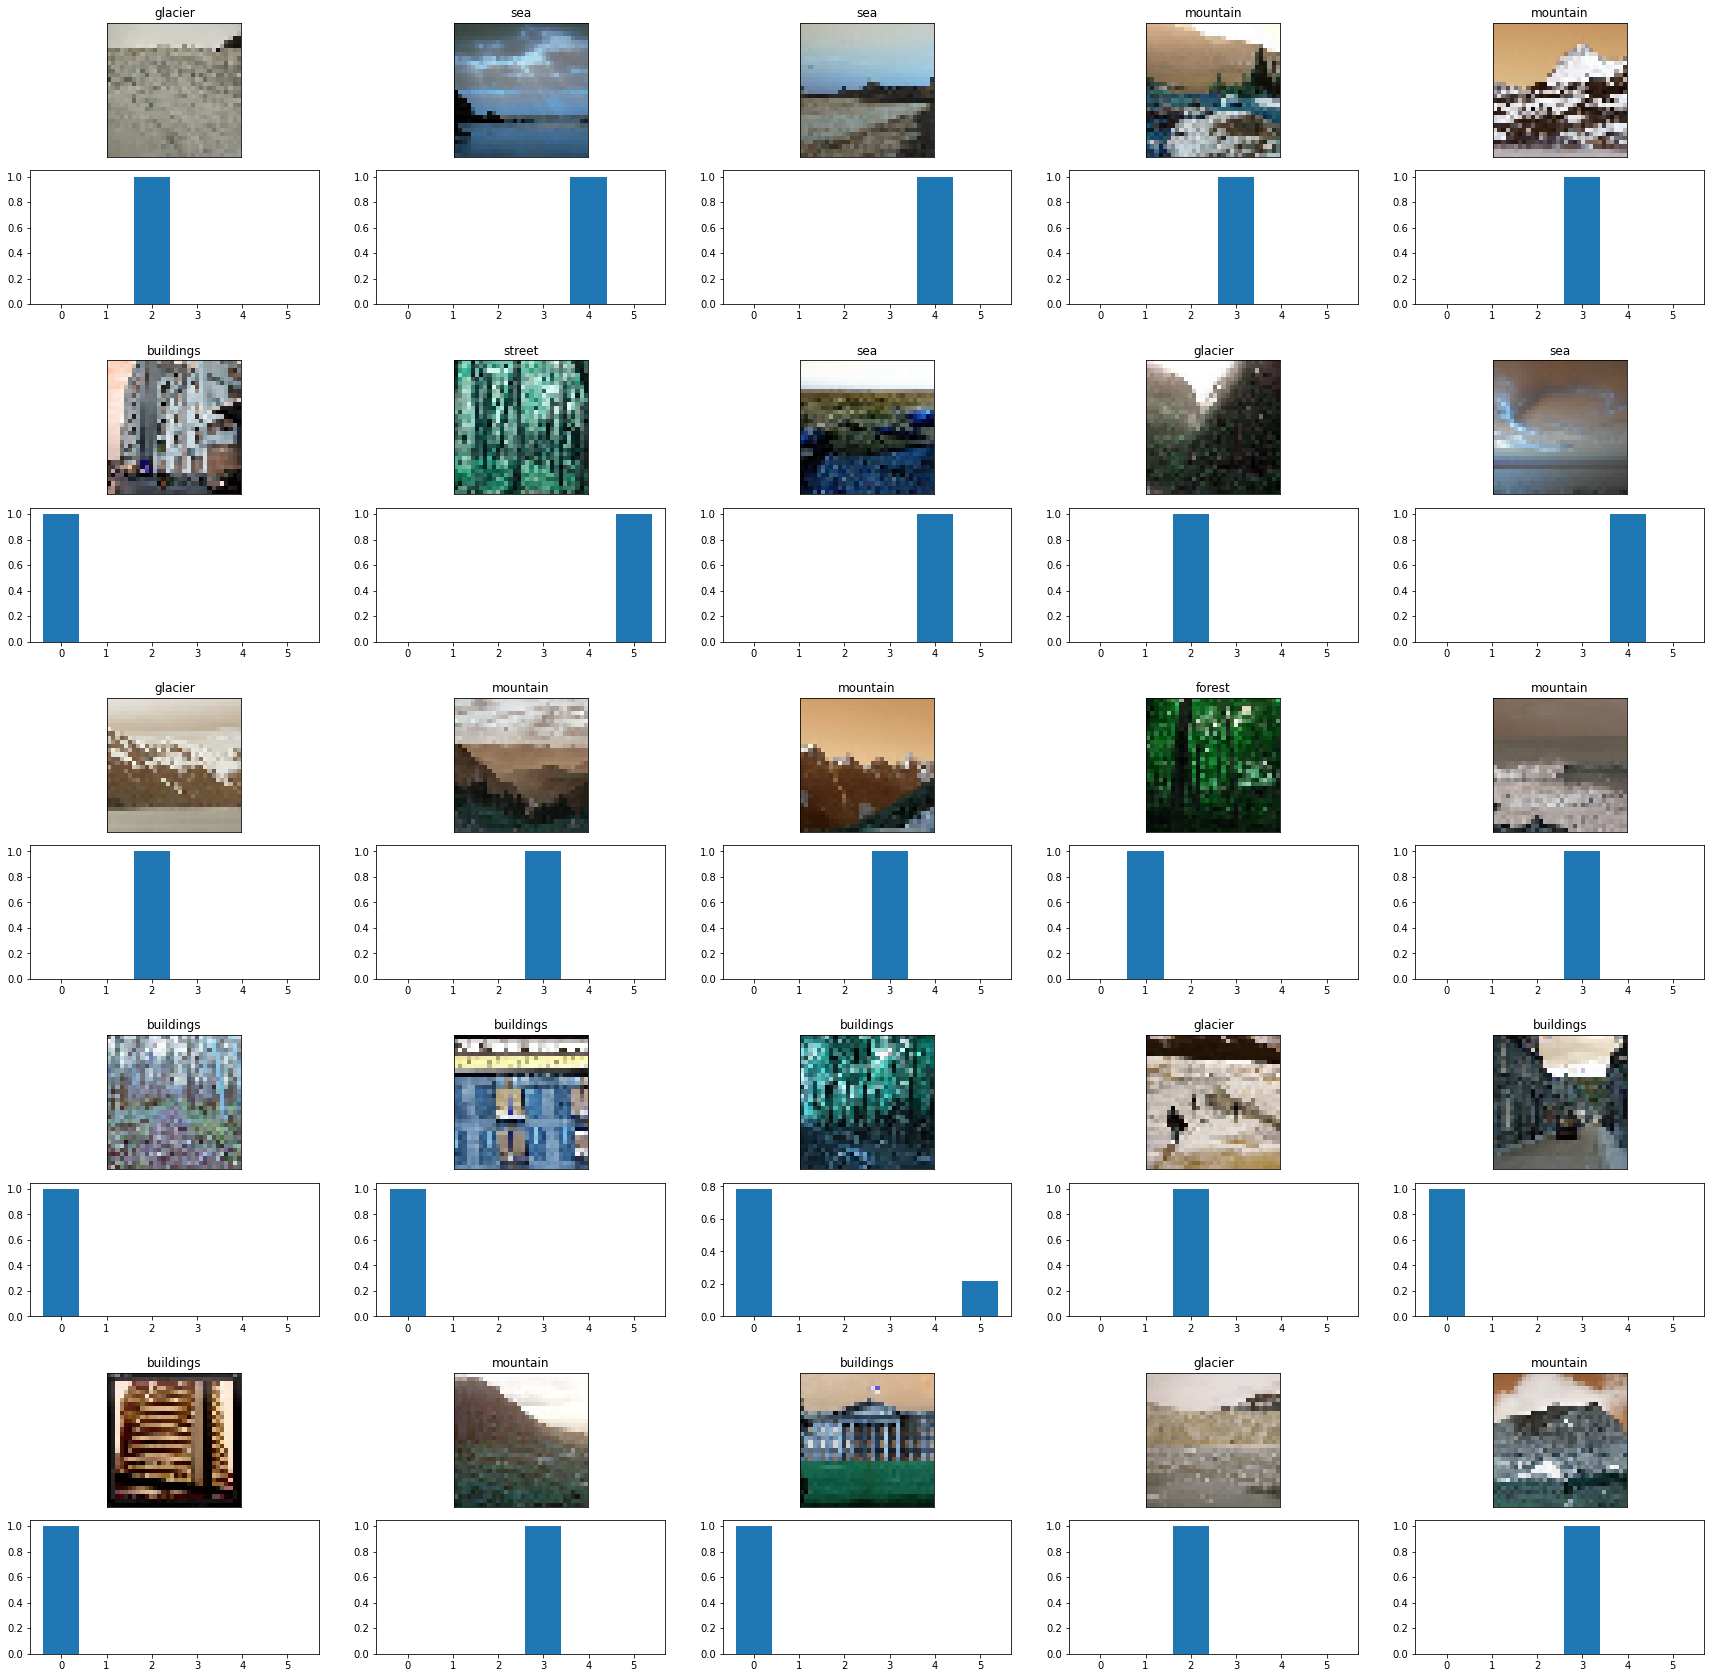

In [39]:
from matplotlib import gridspec
from numpy import argmax

figure = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i, data in enumerate(pred_data.take(25)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    pred_image = np.array([data['image']])
    pred_result = model_3.predict(pred_image)
    pred_class = class_dict[argmax(pred_result, axis=1)[0]]
    pred_prob = pred_result.reshape(6)
    for j in range(2):
        if (j % 2) == 0:
            axes = plot.Subplot(figure, inner[j])
            axes.imshow(pred_image[0])
            axes.set_title(pred_class)
            axes.set_xticks([])
            axes.set_yticks([])
            figure.add_subplot(axes)
        else:
            axes = plot.Subplot(figure, inner[j])
            axes.bar([0, 1, 2, 3, 4, 5], pred_prob)
            figure.add_subplot(axes)

figure.show()

### 開啟 TensorBoard

In [41]:
%load_ext tensorboard
%tensorboard --logdir .

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4173), started 0:03:29 ago. (Use '!kill 4173' to kill it.)